In [ ]:
#If you do  not find the library replace word after install such as !pip3 install keras
!pip3 install  imbalanced-learn

In [4]:
# loading libraries 
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE 
%matplotlib inline

#fix random seed for reproducibility
seed = 7
np.random.seed(seed)
set_random_seed(seed)

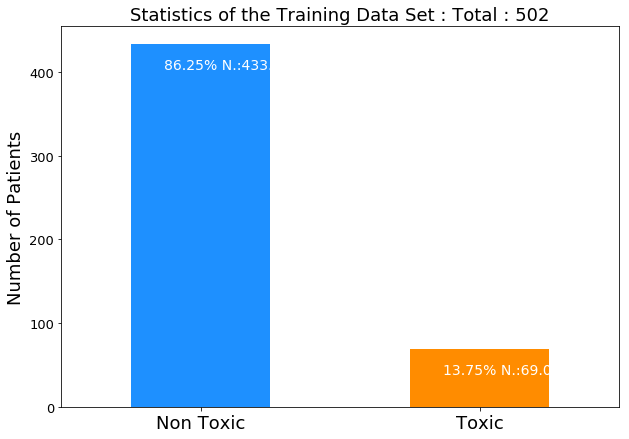

In [5]:
file_name_train = 'train/DVH_Classification_CTDM_BLEED_ID0021.csv'
data_set_1 = pd.read_csv(file_name_train,delimiter=",")
ax = data_set_1['T'].value_counts().plot(kind='bar', figsize=(10,7),
                                        color=['dodgerblue', 'darkorange'],fontsize=13);

ax.set_alpha(0.8)
ax.set_title("Statistics of the Training Data Set : Total : 502", fontsize=18)
ax.set_ylabel("Number of Patients", fontsize=18);
ax.set_yticks([0, 100, 200, 300, 400])
ax.set_xticklabels(["Non Toxic","Toxic"], rotation=0, fontsize=18)
#ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#ax.legend(loc='upper right', frameon=False)
#ax.set_xticklabels(["Toxic"], rotation=90, fontsize=11)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.12, i.get_height()-30, \
            str(round((i.get_height()/total)*100, 2))+'% N.:' + str(i.get_height()), fontsize=14,
                color='white')

In [6]:
#prepare dataset
def iterate_array(data_to_array):
    toxic = 0
    nontoxic = 0 
    data_ar = data_to_array.values
    #print(data_ar)
    for row in data_ar:
        if int(row) == 1 :
            toxic = toxic + 1
        if int(row) == 0 :
            nontoxic = nontoxic + 1
  
    return toxic,nontoxic
#training dataset
file_name_train = 'train/DVH_Classification_CTDM_BLEED_ID0021.csv'
loaded_data = pd.read_csv(file_name_train,header=None,delimiter=",")
features = loaded_data[:1:84]
features = features.drop(features.columns[0], axis=1)
features

loaded_data.drop(loaded_data.index[0], inplace=True)
loaded_data.sample(frac=1)

data_set_1_X = loaded_data.iloc[:,1:85].astype(float)
data_set_1_Y = loaded_data.iloc[:,0]

print('Size of the Data Set : ' , len(data_set_1_X))
tt_toxic,tt_nontoxic = iterate_array(data_set_1_Y)
print('Toxic: ' , tt_toxic, ' NonToxic: ' , tt_nontoxic)
print('Finished Loading')

Size of the Data Set :  502
Toxic:  69  NonToxic:  433
Finished Loading


In [7]:
def iterate_array(data_to_array):
    toxic = 0
    nontoxic = 0 
    for x in np.nditer(data_to_array):
        if x ==1 :
            toxic = toxic + 1
        if x == 0 :
            nontoxic = nontoxic + 1
    return toxic,nontoxic
# encode class values as integers
encoder_data = LabelEncoder()
encoder_data.fit(data_set_1_Y)
encoder_data_Y = encoder_data.transform(data_set_1_Y)

#default 70-30 separation 
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(data_set_1_X, encoder_data_Y, test_size=0.33, random_state=seed) 
print('Separating 70/30 before applying Sampling Generation Algorithm \n')
print('Size of the training set: ' , len(train_X))
tt_toxic,tt_nontoxic = iterate_array(train_Y)
print('Toxic: ' , tt_toxic, ' Non Toxic: ' , tt_nontoxic)
print('Size of the testing set: ',len(test_X))
tr_toxic,tr_nontoxic = iterate_array(test_Y)
print('Toxic: ' , tr_toxic, ' Non Toxic: ' , tr_nontoxic)

Separating 70/30 before applying Sampling Generation Algorithm 

Size of the training set:  336
Toxic:  47  Non Toxic:  289
Size of the testing set:  166
Toxic:  22  Non Toxic:  144


In [8]:
#SMOTE OVERSAMPLING
from collections import Counter
sm = SMOTE(random_state=42,ratio={1:200})
X_train, Y_train = sm.fit_sample(train_X, train_Y)
print('Resampled dataset shape {}'.format(Counter(Y_train)))

Resampled dataset shape Counter({0: 289, 1: 200})


In [9]:
#PLAIN RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

In [18]:
#mean accuracy and out of bag error
from sklearn.metrics import accuracy_score
#print(encoded_Y)
encoder_test = LabelEncoder()
encoder_test.fit(test_Y)
encoded_test_Y = encoder_test.transform(test_Y)

predicted = rf.predict(test_X)
accuracy = accuracy_score(encoded_test_Y, predicted)
print('Out-of-bag score estimate: {0:.2f}'.format(rf.oob_score_))
print('Mean accuracy score: {0:.2f}'.format(accuracy))
cm = confusion_matrix(encoded_test_Y, predicted.round())

Out-of-bag score estimate: 0.84
Mean accuracy score: 0.83


In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

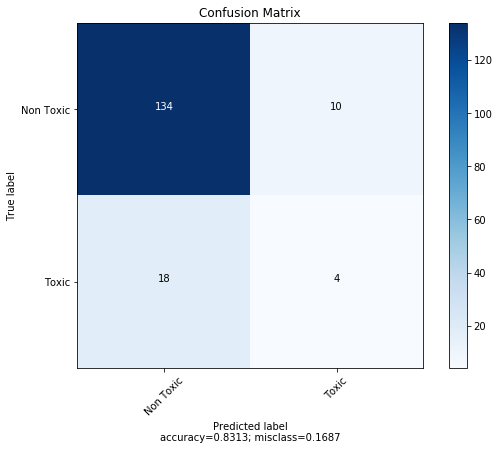

In [20]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Non Toxic', 'Toxic'],
                      title        = "Confusion Matrix")

In [21]:
#changing size of the graph
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 20 and height to 30
fig_size[0] = 20
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

Current size: [6.0, 4.0]


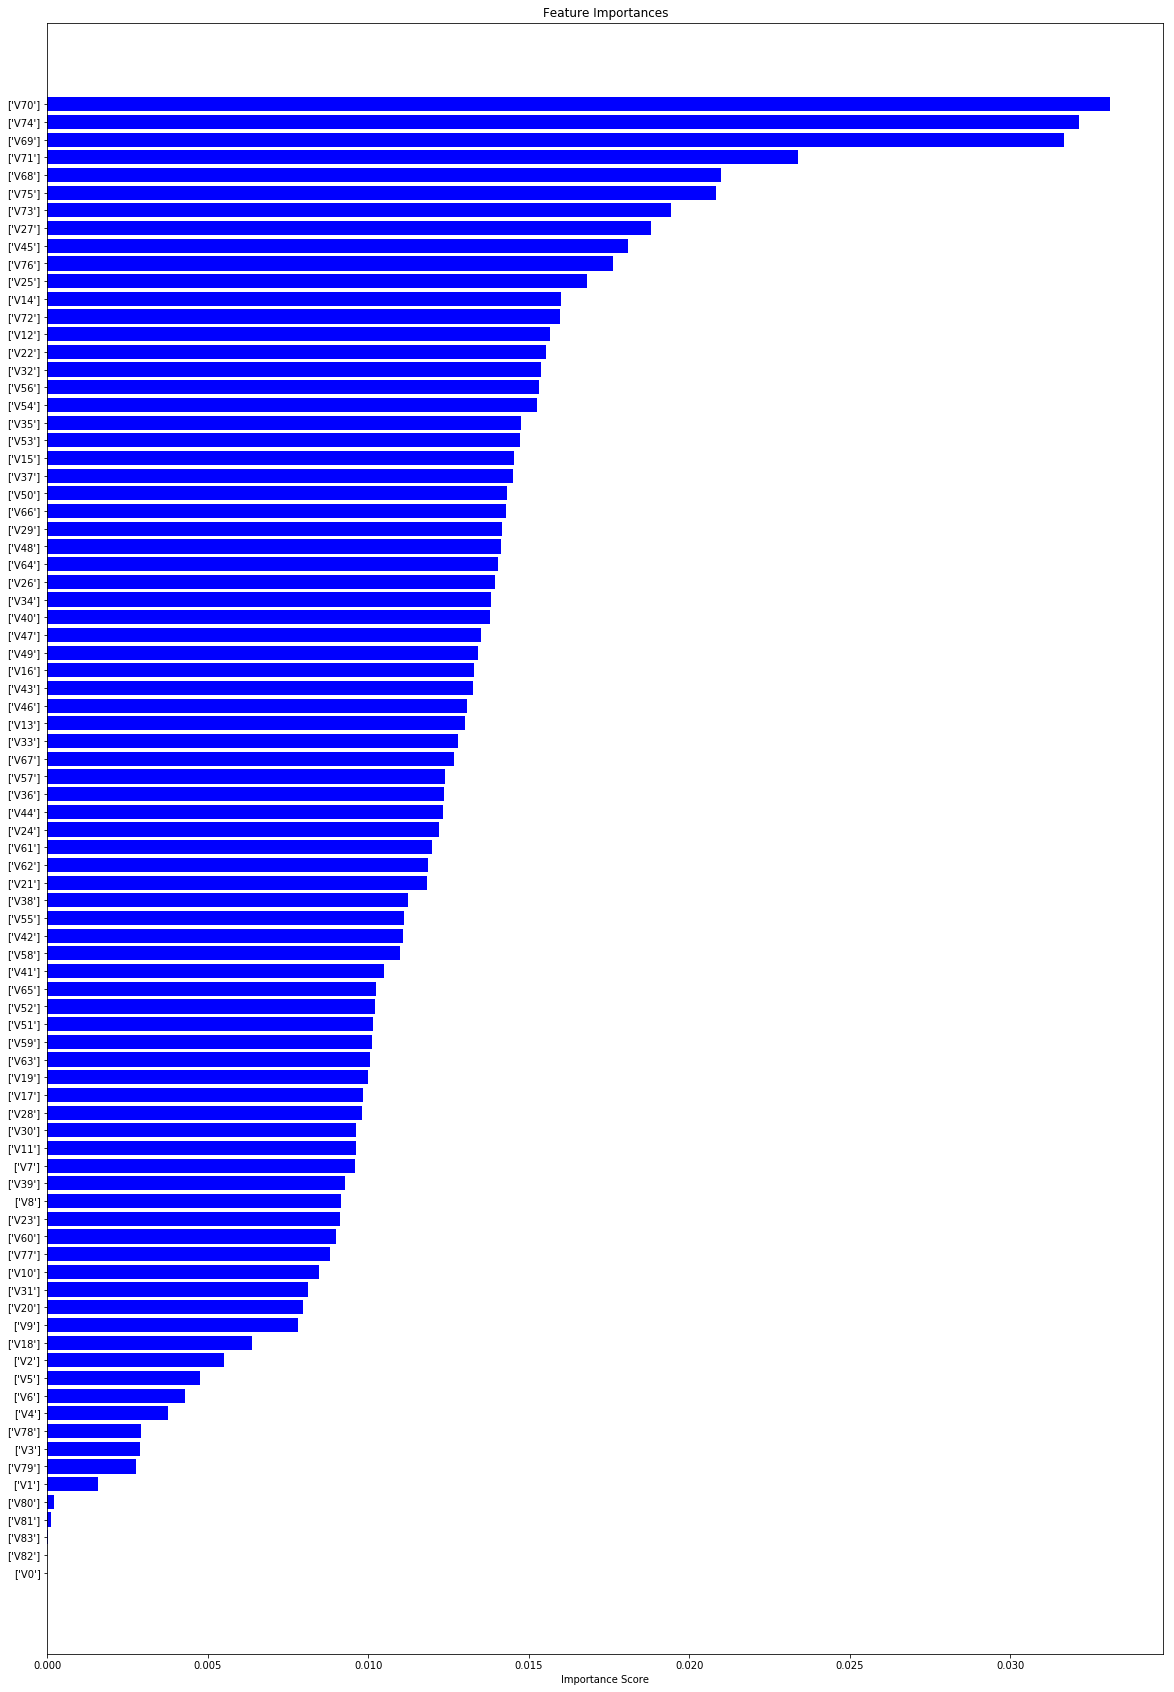

In [22]:
#feature importance using Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)
feature_list =[]
for column_name, column in features.transpose().iterrows():
    feature_list.append(column.values)    
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(feature_list)[indices])
plt.xlabel('Importance Score')
plt.show()

Current size: [20.0, 30.0]
ROC AUC: 0.58


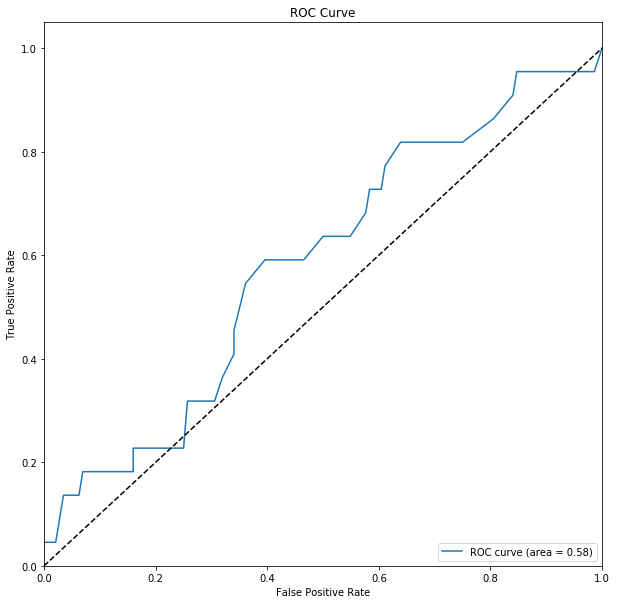

In [23]:
#changing size of the graph
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 20 and height to 30
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

#plotting ROC Curve
from sklearn.metrics import roc_curve, auc

# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(encoded_test_Y, rf.predict_proba(test_X)[:,1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
from sklearn.model_selection import GridSearchCV
#GRID SEARCHING FOR BEST PARAMETERS 
grid_1 = { "n_estimators"      : [100,200,500],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50] }
rf_grid=RandomForestClassifier()
grid_search = GridSearchCV(rf_grid, grid_1, n_jobs=-1, cv=5)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 500], 'max_features': ['sqrt', 'log2', 0.2, 0.5, 0.8], 'min_samples_split': [2, 5, 20, 50], 'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 6, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
#Grid Search Result : Best Score and Best Parameters , It did not improve the accuracy
print('BEST SCORE : ' , grid_search.best_score_)
print('BEST PARAMETERS: ' , grid_search.best_params_)

BEST SCORE :  0.8752556237218814
BEST PARAMETERS:  {'n_estimators': 100, 'max_features': 0.8, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 10}


In [27]:
#Again Calculate Accuracy and 

predicted = grid_search.predict(test_X)
accuracy = accuracy_score(encoded_test_Y, predicted)
print('Out-of-bag score estimate: {0:.2f}'.format(rf.oob_score_))
print('Mean accuracy score: {0:.2f}'.format(accuracy))
cm = confusion_matrix(encoded_test_Y, predicted.round())

Out-of-bag score estimate: 0.84
Mean accuracy score: 0.82


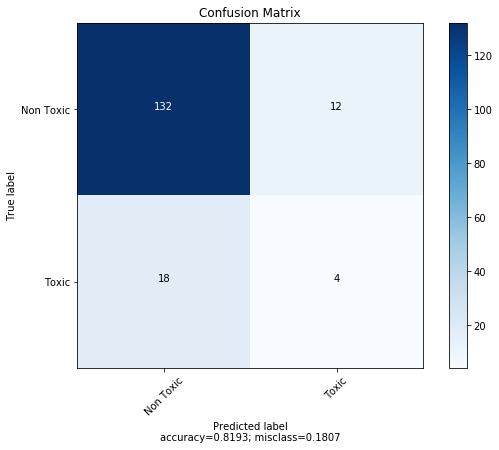

In [28]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Non Toxic', 'Toxic'],
                      title        = "Confusion Matrix")

In [81]:
#import XGBoost Library
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.001)
xgb.fit(X_train, Y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.001, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [82]:
#Accuracy
predicted = xgb.predict(test_X.values)
predictions = [round(value) for value in predicted]
accuracy = accuracy_score(encoded_test_Y, predictions)
print('Accuracy score: {0:.2f}'.format(accuracy))
cm = confusion_matrix(encoded_test_Y, predictions)

Accuracy score: 0.67


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


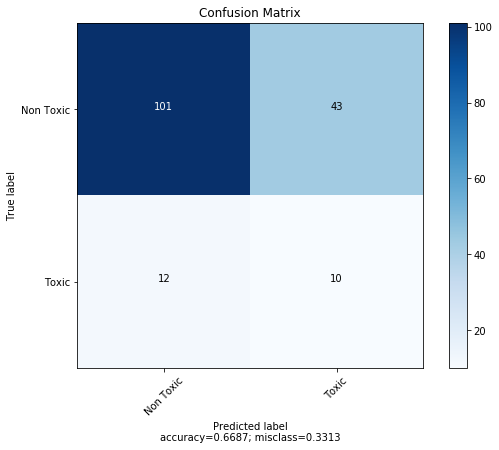

In [83]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Non Toxic', 'Toxic'],
                      title        = "Confusion Matrix")

Current size: [10.0, 10.0]
ROC AUC: 0.64


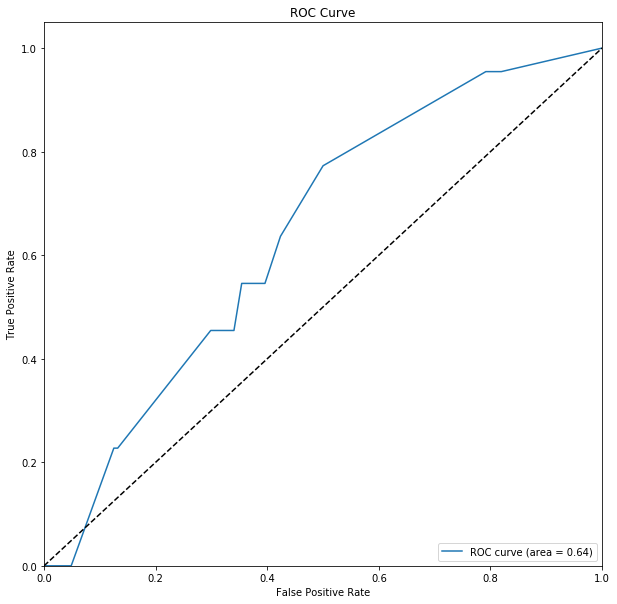

In [84]:
#changing size of the graph
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 20 and height to 30
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

#plotting ROC Curve
from sklearn.metrics import roc_curve, auc

# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(encoded_test_Y, xgb.predict_proba(test_X.values)[:,1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Current size: [10.0, 10.0]


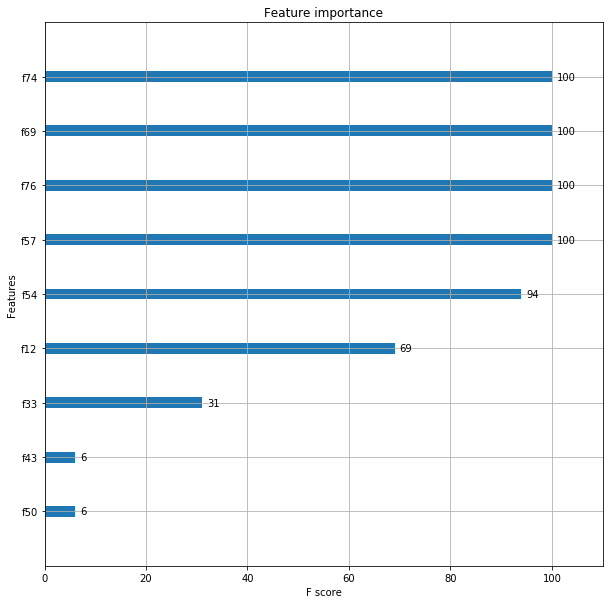

In [85]:
# plot feature importance using XgBoost
from xgboost import plot_importance
from matplotlib import pyplot
#changing size of the graph
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 20 and height to 30
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plot_importance(xgb)
pyplot.show()

In [68]:
#setting up grid search parameter
import scipy.stats as st
grid_2 = {  
    "max_depth": [3, 4, 5,10,15,20],
    "learning_rate": [0.01,0.02,0.03,0.001,0.1,0.2,0.04,0.05],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "min_child_weight": [1, 5, 10],
}

In [70]:
xgb_grid = XGBClassifier()
grid_search = GridSearchCV(xgb_grid, grid_2, n_jobs=4, cv=5,scoring='roc_auc')

In [72]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'subsample': [0.6, 0.8, 1.0], 'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5, 10, 15, 20], 'colsample_bytree': [0.6, 0.8, 1.0], 'min_child_weight': [1, 5, 10], 'learning_rate': [0.01, 0.02, 0.03, 0.001, 0.1, 0.2, 0.04, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [74]:
#Printing best result
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best score:')
print(grid_search.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid_search.best_params_)



 All results:
{'param_colsample_bytree': masked_array(data=[0.6, 0.6, 0.6, ..., 1.0, 1.0, 1.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, ..., 0.05, 0.05, 0.05],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'std_score_time': array([1.93839789e-04, 3.30966210e-05, 3.56806766e-05, ...,
       3.17078425e-05, 8.62608304e-05, 2.97155643e-05]), 'param_min_child_weight': masked_array(data=[1, 1, 1, ..., 10, 10, 10],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'split4_train_score': array([0.93696121, 0.94253772, 0.93925108, ..., 0.9115167 , 0.93996498,
       0.93752694]), 'param_subsample': masked_array(data=[0.6, 0.8, 1.0, ..., 0.6, 0.8, 1.0],
             mask=[False, False, False, ..., False, False, False],
     

In [79]:
xgb_best = XGBClassifier(subsample= 0.8, max_depth= 5, gamma= 0.5, colsample_bytree= 1.0, min_child_weight= 1, learning_rate= 0.2)
xgb_best.fit(X_train, Y_train)
predicted = xgb_best.predict(test_X.values)
predictions = [round(value) for value in predicted]
accuracy = accuracy_score(encoded_test_Y, predictions)
print('Accuracy score: {0:.2f}'.format(accuracy))
cm = confusion_matrix(encoded_test_Y, predictions)

Accuracy score: 0.79


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


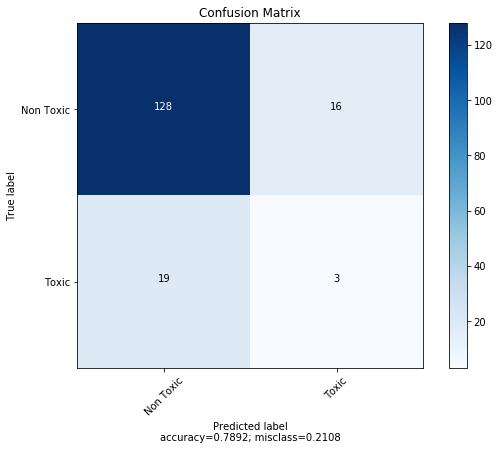

In [80]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Non Toxic', 'Toxic'],
                      title        = "Confusion Matrix")